# Predicting life expectancy using a regression model


### Introduction

The human life span has increased darastically over the past century, increasing from 47.3 years of age in 1900, to 78.8 by 2010 (Crimmins, 2015). Yet this impressive increase in the average life expectacny at birth does not reflect the inequalities in life expectancy which are seen across the socioecinimic divide, not to mention differences in life expectancy and quality which can be seen in gender, income, educational levels, and governance differences.

The World Health Organisation (WHO) released a dataset containing life expectancy and a large variety of health factors, such as immunization, economic, and social factors, for 193 countries between 2000-2015. We will use this data to predict life expectancy using a linear regression model.

### Why these Predictors?
HIV/AIDS has been proven to shorten life expectancy by increasing the risk of other illnesses like heart disease or diabetes. This caused by the virus weakening the immune system making it more susceptible to illnesses and making those illnesses more likely to end in death.
BMI can have a direct impact on life expectancy. As soon as a person is no longer within a healthy BMI range, their life expectancy decreases the further away they get from that range.
Schooling, contrary to BMI, can increase life expectancy. It has been shown in multiple studies that people with higher levels of education tend to have longer life expectancies.


### Preliminary exploratory data analysis

#### Still need:
- Using only training data, *visualize the data* with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(readxl)

life_data <- read_csv("https://raw.githubusercontent.com/kjokjokjo/DSCI_100_Group_Project/main/Life_Expectancy_Data.csv") %>%
na.omit(life_data)

colnames(life_data) <- make.names(colnames(life_data))

head(life_data)

life_expectancy_select <- life_data %>%
select(Life_expectancy, HIV.AIDS, BMI, Schooling)
life_expectancy_select

set.seed(3546)
life_expectancy_split <-initial_split(life_expectancy_select, prop = 0.75, strata = "Life_expectancy")
life_expectancy_training <- training(life_expectancy_split)
life_expectancy_testing <- testing(life_expectancy_split)
life_expectancy_training

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,⋯,Polio,Total_expenditure,Diphtheria,HIV.AIDS,GDP,Population,thinness_1.19_years,thinness_5.9_years,Income_composition_of_resources,Schooling
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,⋯,6,8.16,65,0.1,584.25921,33736494,17.2,17.3,0.479,10.1
Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,⋯,58,8.18,62,0.1,612.69651,327582,17.5,17.5,0.476,10.0
Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,⋯,62,8.13,64,0.1,631.74498,31731688,17.7,17.7,0.470,9.9
Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,⋯,67,8.52,67,0.1,669.95900,3696958,17.9,18.0,0.463,9.8
Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,⋯,68,7.87,68,0.1,63.53723,2978599,18.2,18.2,0.454,9.5
Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,⋯,66,9.20,66,0.1,553.32894,2883167,18.4,18.4,0.448,9.2


Life_expectancy,HIV.AIDS,BMI,Schooling
<dbl>,<dbl>,<dbl>,<dbl>
65.0,0.1,19.1,10.1
59.9,0.1,18.6,10.0
59.9,0.1,18.1,9.9
⋮,⋮,⋮,⋮
44.8,39.8,26.3,10.0
45.3,42.1,25.9,9.8
46.0,43.5,25.5,9.8


Life_expectancy,HIV.AIDS,BMI,Schooling
<dbl>,<dbl>,<dbl>,<dbl>
65.0,0.1,19.1,10.1
59.9,0.1,18.6,10.0
59.5,0.1,17.6,9.8
⋮,⋮,⋮,⋮
44.5,36.7,26.7,9.5
44.8,39.8,26.3,10.0
46.0,43.5,25.5,9.8


In [2]:
### The mean of each variable

life_expectancy_training_mean <- life_expectancy_training %>%
    map_df(mean)
life_expectancy_training_mean

Life_expectancy,HIV.AIDS,BMI,Schooling
<dbl>,<dbl>,<dbl>,<dbl>
69.20517,2.074415,38.0201,12.10872


In [3]:
### The number of missing data of each variable

life_data_original <- read_csv("https://raw.githubusercontent.com/kjokjokjo/DSCI_100_Group_Project/main/Life_Expectancy_Data.csv")

colnames(life_data_original) <- make.names(colnames(life_data_original))

life_select <- life_data_original %>%
    select(Life_expectancy, HIV.AIDS, BMI, Schooling)

colSums(is.na(life_select))

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  Status = col_character()
)

See spec(...) for full column specifications.



Life_expectancy        HIV.AIDS             BMI       Schooling 
             10               0              34             163

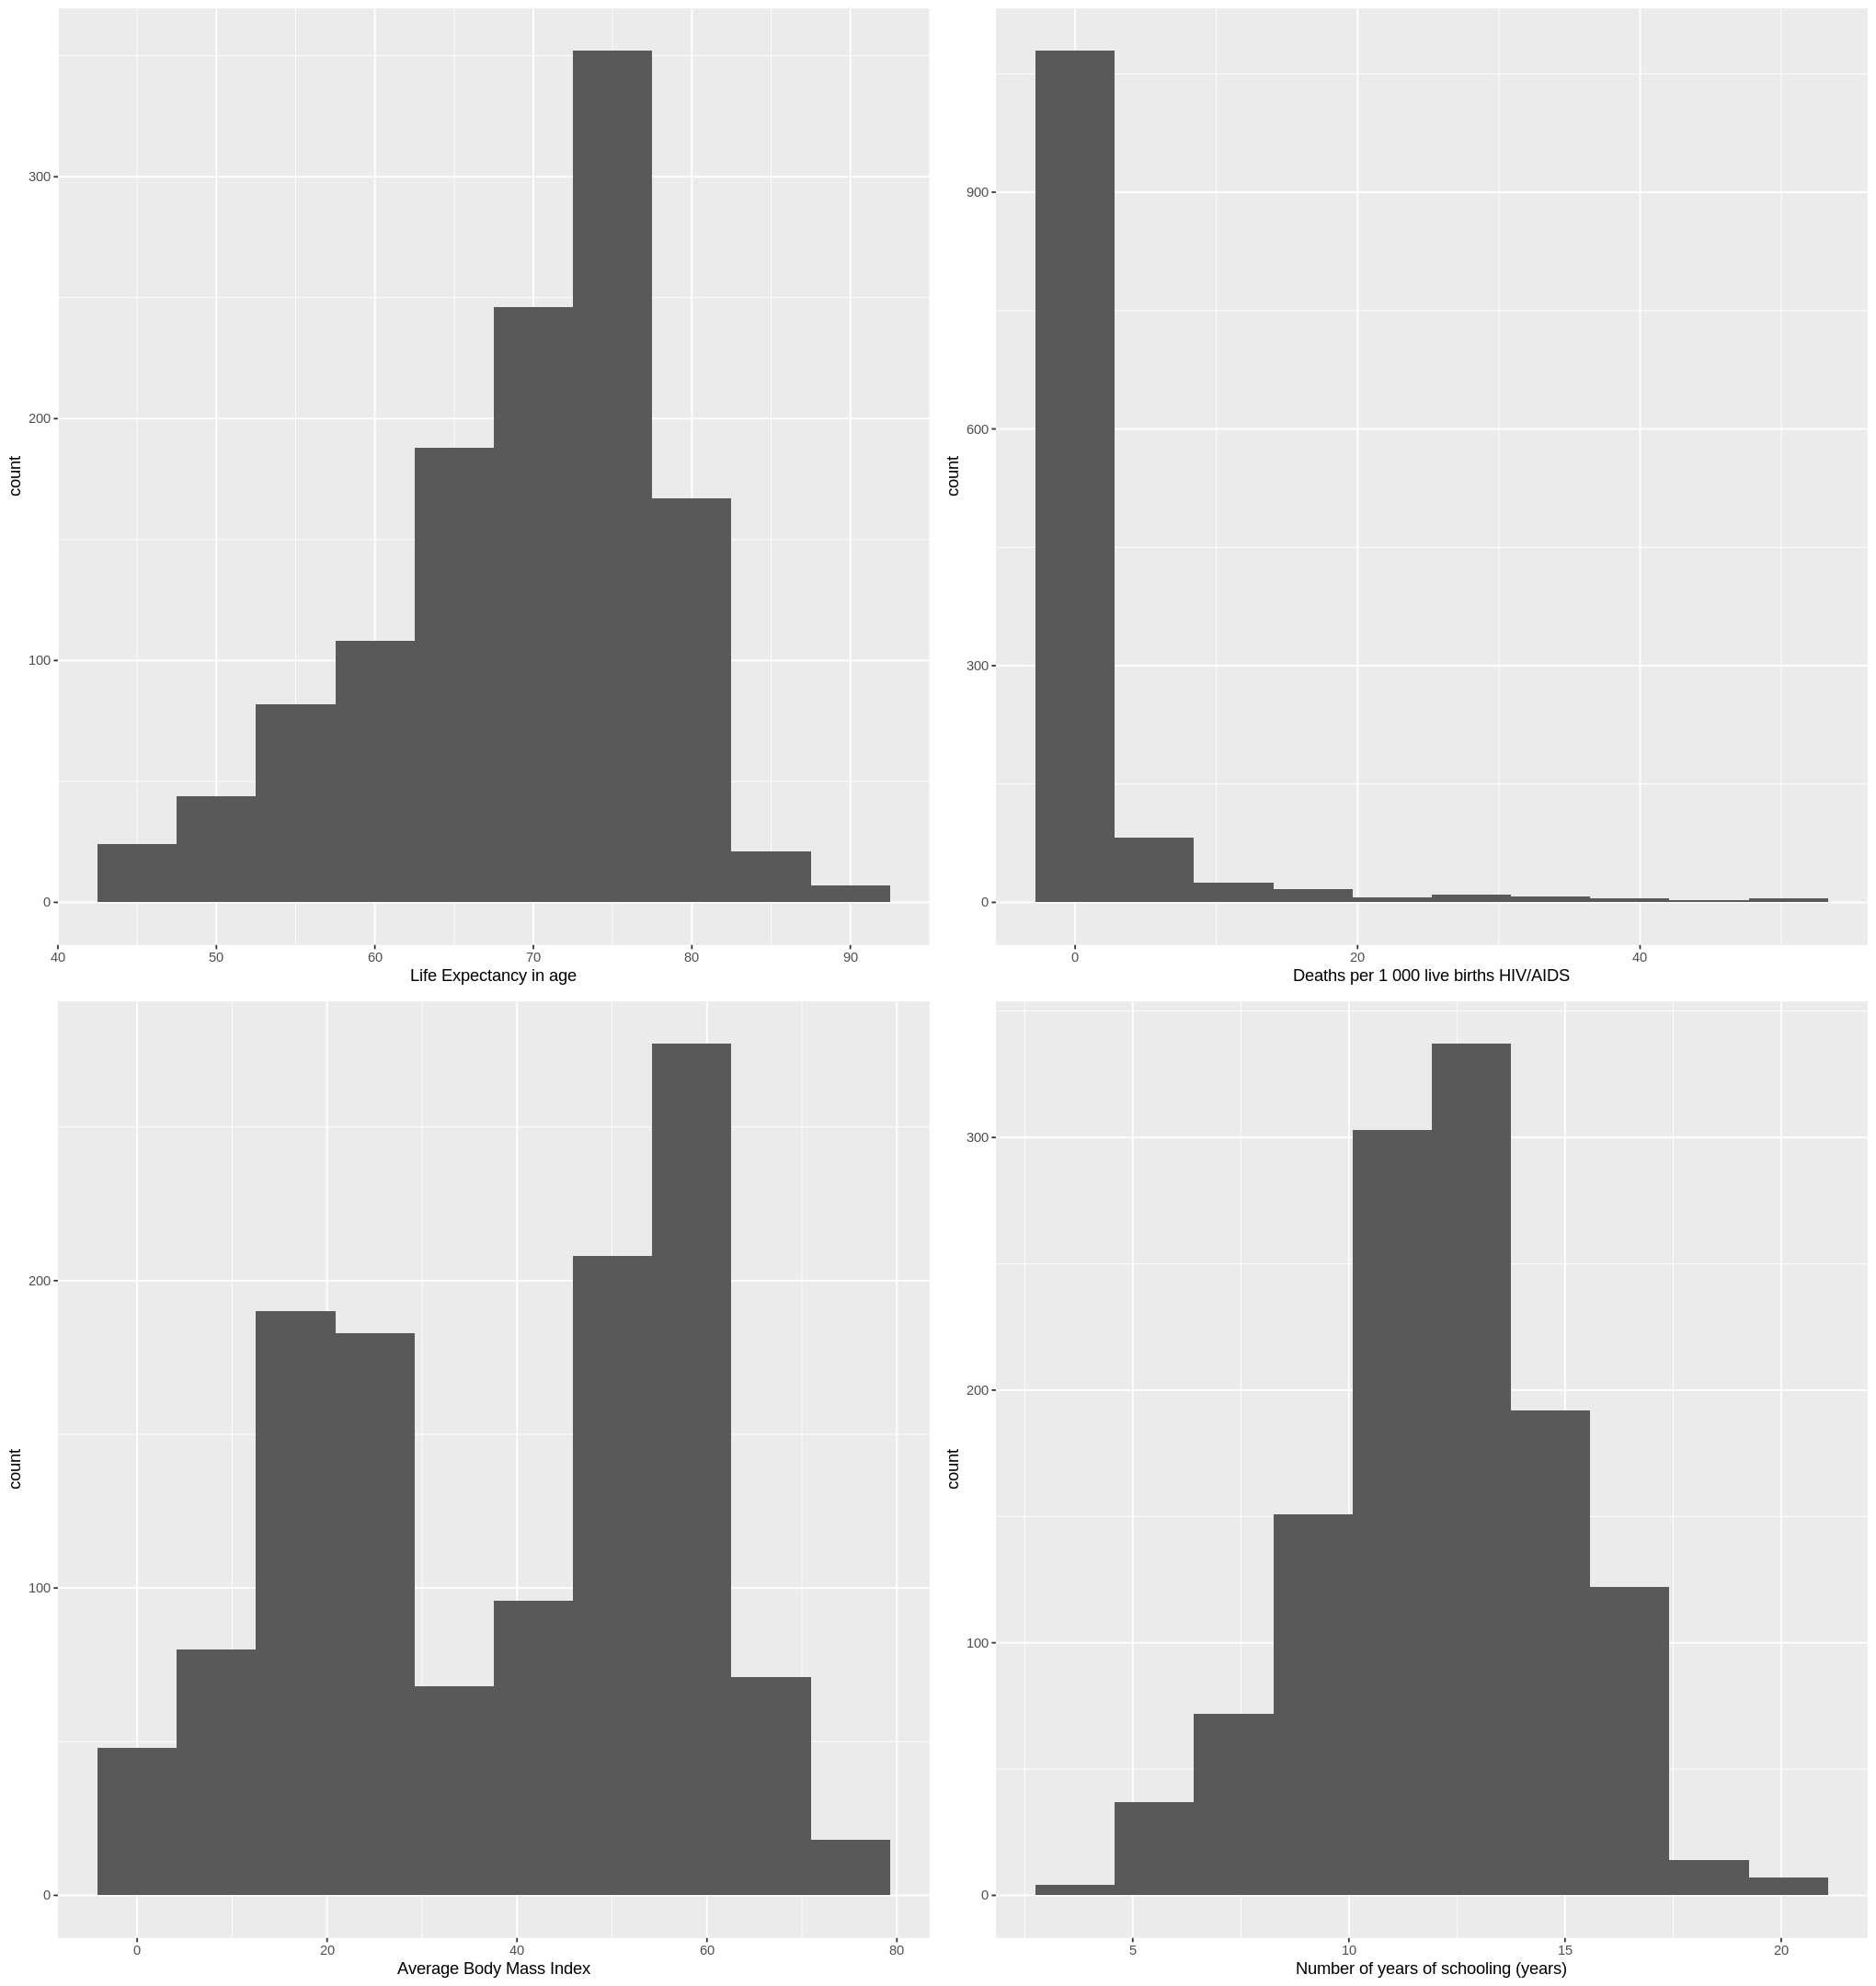

In [108]:
### Distribution of each variable

library(cowplot)
options(repr.plot.width = 17, repr.plot.height = 18)

life_expectancy_hist <- ggplot(life_expectancy_training, aes(x = Life_expectancy)) +
    geom_histogram(bins = 10) +
    xlab("Life Expectancy in age")

hiv_aids_hist <- ggplot(life_expectancy_training, aes(x = HIV.AIDS)) +
    geom_histogram(bins = 10) +
    xlab("Deaths per 1 000 live births HIV/AIDS")

bmi_hist <- ggplot(life_expectancy_training, aes(x = BMI)) +
    geom_histogram(bins = 10) +
    xlab("Average Body Mass Index")

schooling_hist <- ggplot(life_expectancy_training, aes(x = Schooling)) +
    geom_histogram(bins = 10) +
    xlab("Number of years of schooling (years)")

plot_grid(life_expectancy_hist, hiv_aids_hist, bmi_hist, schooling_hist)

##### Methods
- After splitting the data into a test and training set, and scaling where appropriate, we will use a correlation matrix, as in the preliminary exploratory data analysis, to determine which variables from our data set have a strong correlation/relationship with life expectancy, which will be our fixed variable.

- Using Pearson's correlation coefficient we will then determine which of these independent variables can be used to explain life expectancy with a significance level greater than 5% (α=0.05). 

- Using those variables with a statistically significant relationship to life expectancy, we will then predict the life expectancy of the countries in our test data set.

- One way in which our results will be visualized is using a bar chart representing life expectancy by country, with components 


  
#### _Extra Note for group members: Correlation tests if two variables have any kind of relationship, while p-value indicates whether the a result is statistically significant._
  
 - Describe at least one way that you will visualize the results


## Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

We expect to find a positive relationship between immunization and life expectancy. We also expect that developed countries with a high GDP will see a higher life expectancy, however any deviation from the life expectancy which might be predicted solely from per capita income would be able to determine which factors policy makers should focus on in order to improve the health of their citizens.

Determining which predicting variables have the greatest impact on increasing life expectany would enable countries to evaluate how investment in different sectors such as healthcare, or education, in order to increase life expectancy for its citizens. Knowing what factors affect life expectanly would also enable individuals to make decisions in their spending and political affiliation that could improve their own outcomes.

Further questions which could be investigated include looking at whether avearge population density negatively or positively affects life expectancy, how much having health insurance improves life expectacy, and at the .

## References

Crimmins E. M. (2015). Lifespan and Healthspan: Past, Present, and Promise. _The Gerontologist,_ 55(6), 901–911. https://doi.org/10.1093/geront/gnv130

Novak, A., Čepar, Z., and Trunk, A. (2016). The role of expected years of schooling among life expectancy determinants. _International Journal of Innovation and Learning_. 20(1). https://www.inderscienceonline.com/doi/pdf/10.1504/IJIL.2016.076673

### (suggested) Style Guide for Group (use three hashtags, ###, to create sub headings

**use stars for bold type** **

- use a dash - to get a Bullet
  - and another for an extra bullet 
  - or two...
  -use apostrophes ' for functions/code unless adding to a code box, ie: `read_csv`
  - and underscores, _ , for _italics_
